#**News Article Scraper**

**Purpose**: Extracts **category**, **content**, and **AI-generated summaries** from news URLs.

## Key Features
- Scrapes articles using `newspaper3k` + fallback to `requests-html`
- Filters by length (300-10k chars) and category
- Auto-retries failed downloads
- Output: Clean CSV with `[category, content, summary]`


**Dependencies**

In [1]:
!pip install newspaper3k requests-html tqdm lxml[html_clean]

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.3 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=e1b4c333c19bb84f2fe6115

**Imports, configuration and goodle drive mountain**

In [2]:
import pandas as pd
from newspaper import Article, Config
from requests_html import HTMLSession
import time
import random
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Configure scraper
config = Config()
config.browser_user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
config.request_timeout = 20

Mounted at /content/drive


**Inpuut and output paths**

In [12]:
# Run the scraper (update paths)
input_path = '/content/news_url.csv'
output_path = '/content/drive/MyDrive/news_dataset.csv'

**Reading the dataset**

In [13]:
df = pd.read_csv(input_path)
df.head()

,URL,CATEGORY
0,http://www.latimes.com/business/money/la-fi-mo...,business
1,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,business
2,http://www.ifamagazine.com/news/us-open-stocks...,business
3,http://www.ifamagazine.com/news/fed-risks-fall...,business
4,http://www.moneynews.com/Economy/federal-reser...,business


**Checking the null value**

In [14]:
df.isnull().sum()

,0
URL,0
CATEGORY,0


**Data description**

In [17]:
df.describe()

,URL,CATEGORY
count,422419,422419
unique,422223,4
top,http://www.japantimes.co.jp/news/2014/04/18/wo...,entertainment
freq,5,152469


**Dataset size**

In [19]:
df.shape

(422419, 2)

**Visualizing the category distribution**

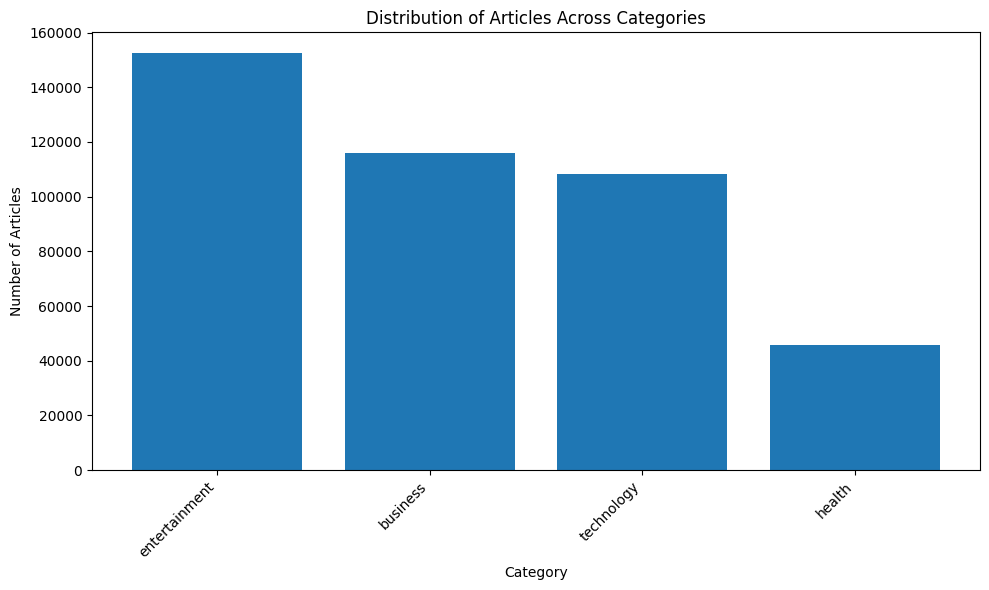

In [20]:
category_counts = df['CATEGORY'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel("Category")
plt.ylabel("Number of Articles")
plt.title("Distribution of Articles Across Categories")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**Scrapping the contents and their respective summmary**

The funtion Scrapes a news article and returns its category, content, and AI summary.

**Flow**:
1. Tries scraping with `newspaper3k`
2. Falls back to JavaScript rendering if needed
3. Validates content length (300-10k chars)
4. Returns `None` after max retries

**Returns**:  
`{'category':str, 'content':str, 'summary':str}` or `None`

In [3]:
def download_content_summary(url, category, max_retries=2):
    for _ in range(max_retries):
        try:
            # Attempt with newspaper3k
            article = Article(url, config=config)
            article.download()
            article.parse()

            if 300 < len(article.text) < 10000:  # Length filter
                article.nlp()
                return {
                    'category': category,
                    'content': article.text,
                    'summary': article.summary
                }
        except:
            try:
                # Fallback for JavaScript sites
                session = HTMLSession()
                response = session.get(url, timeout=10)
                response.html.render(timeout=15)
                article = Article(url, config=config)
                article.download(input_html=response.html.html)
                article.parse()
                if 300 < len(article.text) < 10000:
                    article.nlp()
                    return {
                        'category': category,
                        'content': article.text,
                        'summary': article.summary
                    }
            except:
                time.sleep(random.uniform(1, 3))
    return None  # Failed after retries

### `process_data(input_csv, output_path)`
Processes news articles from a CSV to extract category, content and summaries.

**Inputs**:
- `input_csv`: Path to CSV containing URL and CATEGORY columns
- `output_path`: Where to save results

**Actions**:
1. Filters articles by valid categories (health/business/technology/entertainment)
2. Scrapes each URL for content and generates summaries
3. Saves results to CSV with columns: `[category, content, summary]`

**Output**: Returns DataFrame and saves CSV

In [4]:
def process_data(input_csv, output_path):
    # Load CSV and filter valid categories
    df = pd.read_csv(input_csv)
    valid_categories = ['health', 'business', 'technology', 'entertainment']
    df = df[df['CATEGORY'].isin(valid_categories)].copy()

    # Process articles
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Scraping Articles"):
        result = download_content_summary(row['URL'], row['CATEGORY'])
        if result:
            results.append(result)
        time.sleep(random.uniform(0.5, 2))  # Rate limiting

    # Save results
    result_df = pd.DataFrame(results)
    result_df.to_csv(output_path, index=False)
    print(f"\nSaved {len(result_df)} articles to {output_path}")
    return result_df

In [7]:
data = process_data(input_path, output_path)
data.head()

,CATEGORY,CONTENT,SUMMARY
0,business,The Federal Reserve approved Ally Financial In...,The Federal Reserve approved Ally Financial In...
1,business,— Major shareholders of Duke Energy Corp. have...,— Major shareholders of Duke Energy Corp. have...
2,business,Photos taken earlier this month show that Nort...,Photos taken earlier this month show that Nort...
3,business,Thanks to dogged reporting by the Associated P...,Thanks to dogged reporting by the Associated P...
4,business,The energy giant says it is committed to clean...,The energy giant says it is committed to clean...


In [8]:
data.shape

(36891, 3)